In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model pre-trained on ImageNet data
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Display the model structure
model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [2]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, BatchNormalization

# Add new layers for gesture recognition
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 neurons
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout with a rate of 0.5
predictions = Dense(11, activation='softmax')(x)  # 11 classes including 'unknown'

# Model
gesture_model = Model(inputs=model.input, outputs=predictions)

# Compile the model
gesture_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_images(directory):
    images = []
    labels = []

    for folder in os.listdir(directory):
        if folder in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'unknown']:
            label = folder if folder != 'unknown' else 10  # Assign '10' to 'unknown'
            folder_path = os.path.join(directory, folder)

            for file in os.listdir(folder_path):
                if file.endswith('.jpg'):
                    file_path = os.path.join(folder_path, file)
                    image = load_img(file_path, target_size=(224, 224))
                    #image = load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                    image = img_to_array(image)
                    #image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB
                    image /= 255.0  # Normalize pixel values

                    images.append(image)
                    labels.append(label)

    return np.array(images), np.array(labels)

In [5]:
# Load and preprocess data
X, y = load_images('/Users/noelnebu/Downloads/Sign Language for Numbers/')

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

print("len(X)", len(X))

print("len(X_train)", len(X_train), "len(X_val)", len(X_val))
print("X_train[0].shape", X_train[0].shape)

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
val_test_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(X_train, tf.keras.utils.to_categorical(y_train, num_classes=11), batch_size=32)
val_generator = val_test_datagen.flow(X_val, tf.keras.utils.to_categorical(y_val, num_classes=11), batch_size=32)
test_generator = val_test_datagen.flow(X_test, tf.keras.utils.to_categorical(y_test, num_classes=11), batch_size=32)


len(X) 16980
len(X_train) 11886 len(X_val) 2547
X_train[0].shape (224, 224, 3)


Raw Images:


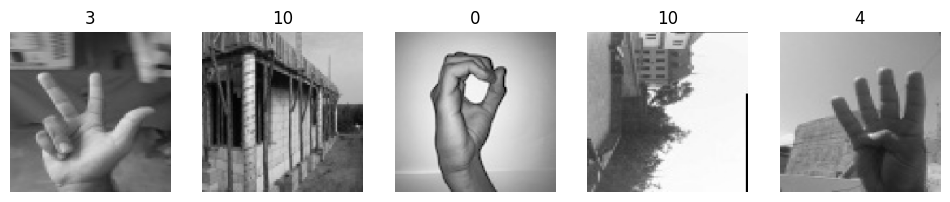

Augmented Images:


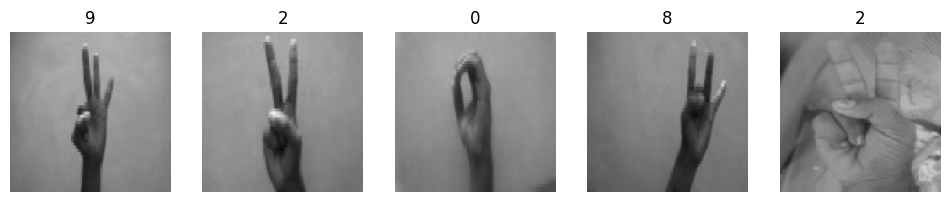

Validation Images:


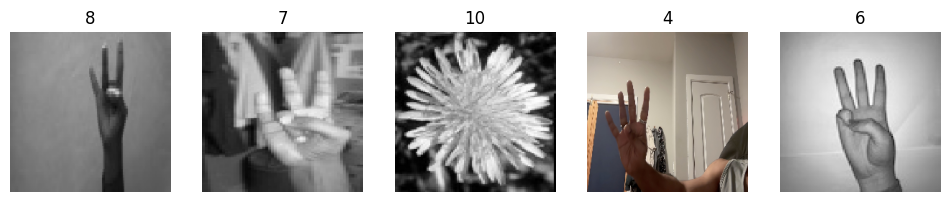

Test Images:


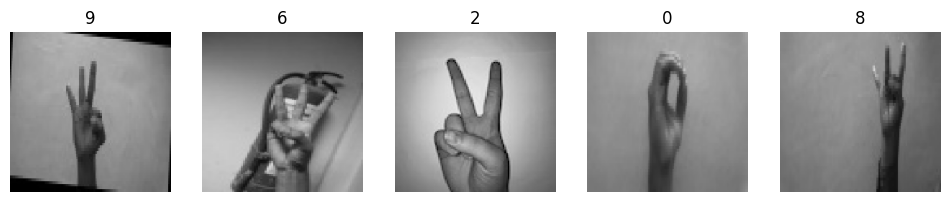

In [9]:
import matplotlib.pyplot as plt

# Function to display images
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))  # Assuming labels are one-hot encoded
        plt.axis('off')
    plt.show()

# Display raw images
print("Raw Images:")
show_images(X_train[:5], tf.keras.utils.to_categorical(y_train[:5], num_classes=11))

# Display augmented images
print("Augmented Images:")
augmented_images, augmented_labels = next(train_generator)
show_images(augmented_images, augmented_labels)

# Display val images
print("Validation Images:")
val_images, val_labels = next(val_generator)
show_images(val_images, val_labels)

# Display test images
print("Test Images:")
test_images, test_labels = next(test_generator)
show_images(test_images, test_labels)


In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Add the scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with the scheduler
history = gesture_model.fit(
    train_generator,
    steps_per_epoch=360,
    epochs=10,
    validation_data=val_generator,
    validation_steps=77,
    callbacks=[lr_scheduler]
)

Epoch 1/10
360/360 [==============================] - 386s 1s/step - loss: 0.5543 - accuracy: 0.8383 - val_loss: 3.6172 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 2/10
360/360 [==============================] - 425s 1s/step - loss: 0.1741 - accuracy: 0.9484 - val_loss: 6.6503 - val_accuracy: 0.5296 - lr: 0.0010
Epoch 3/10
360/360 [==============================] - 413s 1s/step - loss: 0.1143 - accuracy: 0.9654 - val_loss: 1.6657 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 4/10
360/360 [==============================] - 422s 1s/step - loss: 0.0998 - accuracy: 0.9698 - val_loss: 1.5683 - val_accuracy: 0.7719 - lr: 0.0010
Epoch 5/10
360/360 [==============================] - 458s 1s/step - loss: 0.0911 - accuracy: 0.9744 - val_loss: 1.0653 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 6/10
360/360 [==============================] - 450s 1s/step - loss: 0.0557 - accuracy: 0.9849 - val_loss: 1.6608 - val_accuracy: 0.7622 - lr: 9.0484e-04
Epoch 7/10
360/360 [==============================] - 437s 1

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = gesture_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

80/80 [==============================] - 16s 201ms/step - loss: 0.0992 - accuracy: 0.9784
Test Loss: 0.09921158850193024
Test Accuracy: 0.9784059524536133


In [12]:
gesture_model.save('hand_gesture_model.keras')